# convolution filter example AQ 5NOV21

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.measure import profile_line

# para importar una funcion desde UtilsNotebook.ipynb estamos intentando la solucion de 
# https://stackoverflow.com/questions/44116194/import-a-function-from-another-ipynb-file: pip install ipynb --upgrade
#hemos instalado ipynb con pips desde un cmd window en el enviroment aqtest
import ipynb #para importar una funcion de otro ipynb file
from ipynb.fs.full.UtilsNotebook import disp2img

#%matplotlib inline #esta opcion genera una figura inline no interactiva, y si funciona con jupyter lab
#esta opcion lanza una ventana con un plot interactivo QT que se puede matar con el close_window, y si funciona con jupyter lab
# %matplotlib qt 

#utils
def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

ModuleNotFoundError: No module named 'ipynb'

In [ ]:
# Available matplotlib backends to change the backend on the fly see 
# https://stackoverflow.com/questions/3285193/how-to-change-backends-in-matplotlib-python
%matplotlib --list

## Init and generate data

In [45]:
NR, NC, NP=(512, 511, 1)

x=np.arange(0, NC)
x=x-0.5*NC
y=np.arange(0, NR)
y=y-0.5*NR

X,Y=np.meshgrid(x,y)

In [46]:
#fringe period in Px
Tx, Ty=(30, 30)

In [47]:
phi=2*np.pi*(X/Tx + Y/Ty)

In [48]:
b=100 #GV
sigma_x, sigma_y=(0.25*NC, 0.25*NR)

m=np.exp(-X**2/(2*sigma_x**2) - Y**2/(2*sigma_y**2))
gc=m*np.cos(phi)
gs=m*np.sin(phi)
z=gc+1j*gs

In [49]:
#interactive contour labeling
%matplotlib qt
from matplotlib import pyplot as plt
CS = plt.contour(X, Y, m, 20)
#este solo funciona con %matplotlib qt 
CL = plt.clabel(CS, manual=True)
plt.close()

Select label locations manually using first mouse button.
End manual selection with second mouse button.


C:\Users\juaqu\AppData\Local\Temp/ipykernel_45576/1715268172.py:6: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  CL = plt.clabel(CS, manual=True)


C:\Users\juaqu\AppData\Local\Temp/ipykernel_45576/1238797237.py:7: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
  p = profile_line(np.abs(z), pts[0], pts[1])


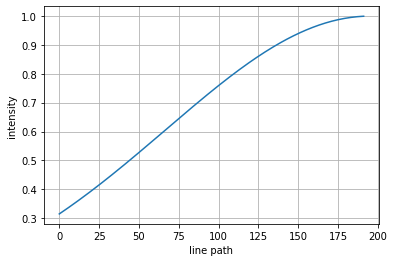

In [50]:
%matplotlib qt
plt.imshow(np.abs(z))
n_points=2;
pts = plt.ginput(n_points, timeout=-1)
plt.close()
pts
p = profile_line(np.abs(z), pts[0], pts[1])

#si queremos el plot offline para zoom etc dejar el backend de matplotlib en qt
%matplotlib inline
plt.plot(p)
plt.ylabel('intensity')
plt.xlabel('line path')
plt.grid()


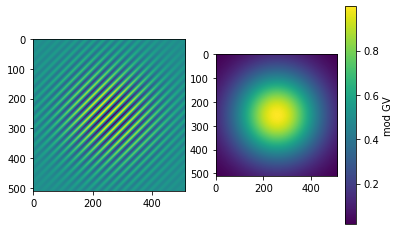

In [51]:
%matplotlib inline
plt.subplot(121);plt.imshow(z.real) # cosine
plt.subplot(122);plt.imshow(np.abs(z)) # modulation
cbar = plt.colorbar()
cbar.set_label('mod GV')

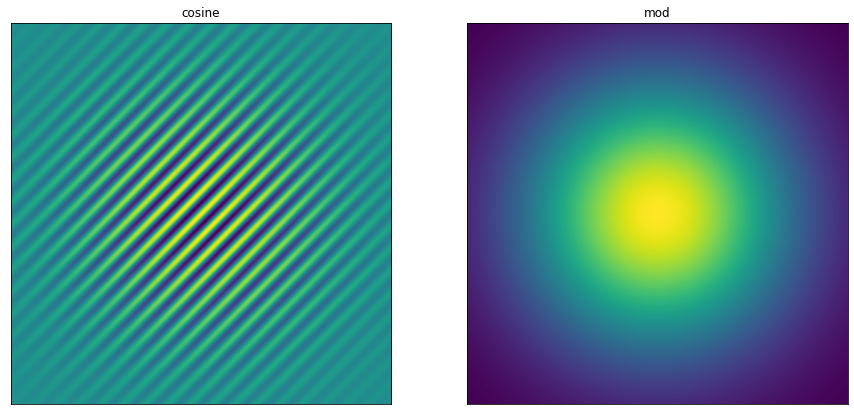

In [52]:
disp2img(z.real, np.abs(z),  img1Title="cosine", img2Title="mod", figSize=(15,15));

### Modulation mask

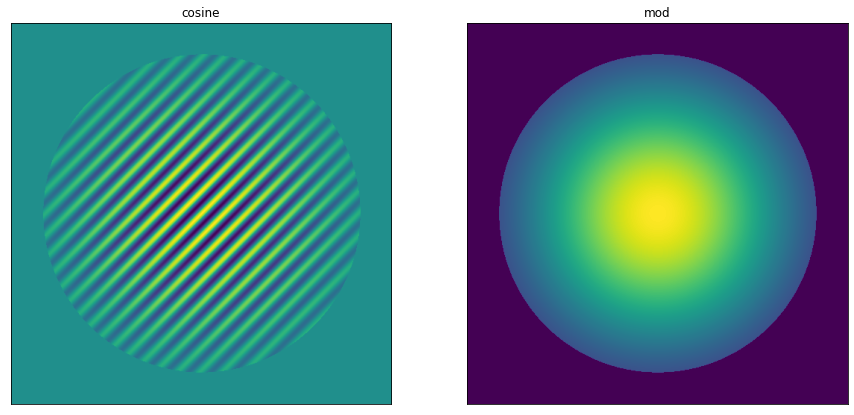

In [53]:
#working with ROIs
mz=np.abs(z)
th=0.25;
M=mz>th
disp2img(M*z.real, M*np.abs(z),  img1Title="cosine", img2Title="mod", figSize=(15,15));

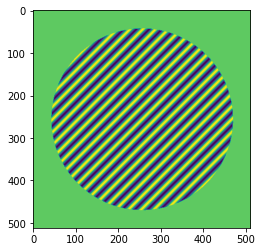

In [54]:
#working with ROIs
zNorm=1j*np.ones(z.shape)
zNorm[M]=z[M]/mz[M]
#realpart outside to 0.5 and imag to 1.5
zNorm[np.logical_not(M)]+=0.5 
zNorm.shape
plt.imshow(zNorm.real)

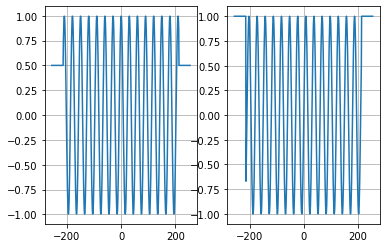

In [55]:
c=int(0.5*NC)
plt.subplot(121);plt.plot(y, zNorm[:, c].real);  plt.grid()# cosine
plt.subplot(122); plt.plot(y, zNorm[:, c].imag);  plt.grid() # modulation


Text(0, 0.5, 'GV')

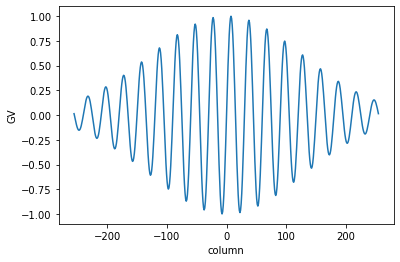

In [56]:
r=int(0.5*NR)
plt.plot(x,gs[r,:])
plt.xlabel("column")
plt.ylabel("GV")

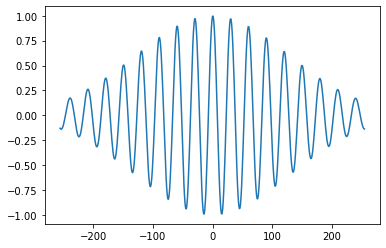

In [57]:
c=int(0.5*NC)
plt.plot(y, z.real[:, c])

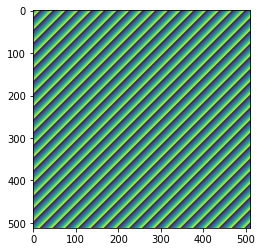

In [58]:
a=np.angle(z)
plt.imshow(a)

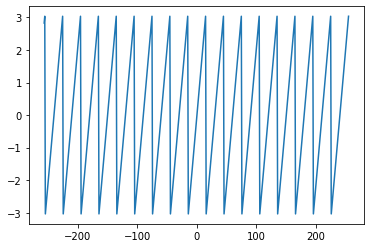

In [59]:
plt.plot(y, a[:, c])

In [60]:
z_size=z.shape
print(z_size)

(512, 511)


## Conv Kernel and filtering

### low pass filter

In [61]:
filter_size=(19, 19)
h = np.ones(filter_size) /(filter_size[0]*filter_size[1]) 
print(h.shape)
print(h.sum())

(19, 19)
1.0000000000000002


In [62]:
z_filt1=cv2.filter2D(z.real, -1, h)+1j*cv2.filter2D(z.imag, -1, h)

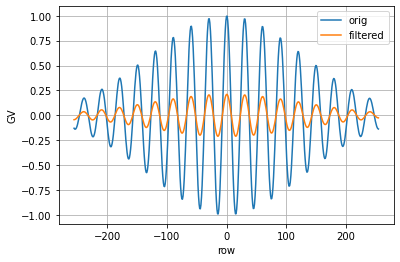

In [63]:
# in this case filtered signal is in phase with the original because kernel is lopass and kernel size is odd
plt.plot(y, z.real[:, c], y, z_filt1.real[:, c])
plt.xlabel("row")
plt.ylabel("GV")
plt.legend(['orig', 'filtered'])
plt.grid()
assert z.shape==z_filt1.shape

In [64]:
#filter the ROI
Mfilt=cv2.filter2D(M.astype('double'), -1, h)

In [65]:
%matplotlib qt
plt.imshow(Mfilt)
n_points=2
pts = plt.ginput(n_points, timeout=-1)
plt.close()
esf = profile_line((Mfilt-M), pts[0], pts[1])
N=esf.size
esf_axis=np.arange(0, N)
#el grad es una aproximacion, habria que tener en cuenta el espaciado
lsf=np.gradient(esf)
#si queremos el plot offline para zoom etc dejar el backend de matplotlib en qt
%matplotlib qt
plt.plot(esf_axis, esf, esf_axis, lsf)
plt.legend(['ESF', 'LSF'])
plt.grid()
plt.xlabel('px')

C:\Users\juaqu\AppData\Local\Temp/ipykernel_45576/2764860544.py:6: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
  esf = profile_line((Mfilt-M), pts[0], pts[1])


Text(0.5, 0, 'px')

In [66]:
esf_axis.shape

(115,)

### Complex filter 

In [67]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],

                   [-10+0j, 0+ 0j, +10 +0j],

                   [ -3+3j, 0+10j,  +3 +3j]]) # Gx + j*Gy

# filter the mask


In [68]:
z_filt2=cv2.filter2D(z.real, -1, scharr.real)+1j*cv2.filter2D(z.real, -1, scharr.imag)

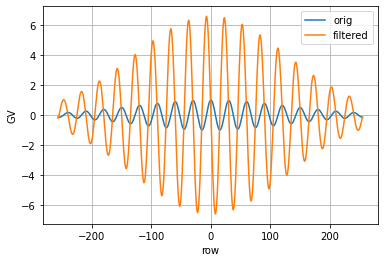

In [70]:
# in this case filtered signal is in cuadrature with the original because kernel is a derivative
%matplotlib inline
plt.plot(y, z.real[:, c], y, z_filt2.real[:, c])
plt.xlabel("row")
plt.ylabel("GV")
plt.legend(['orig', 'filtered'])
plt.grid()